In [1]:
import sys
import os
import pandas as pd
import seaborn as sns
import glob

In [2]:
sys.path.append('..')

In [18]:
from icenode.train_icenode_2lr import ICENODE
from icenode.train_icenode_uniform2lr import ICENODE as ICENODE_UNIFORM
from icenode.train_gram import GRAM
from icenode.train_retain import RETAIN

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [86]:
from icenode.utils import load_config, load_params


HOME = os.environ.get('HOME')

# MIMIC-III Dataset Directory
mimic3_dir = f'{HOME}/GP/ehr-data/mimic3-transforms'


def get_trained_params(trained_dir, criterion):
    params = {}
    for clf, clf_dir in trained_dir.items():
        csv_files =  glob.glob(f'{clf_dir}/*.csv', recursive=False)
        dfs = [pd.read_csv(csv_file, index_col=[0]) for csv_file in csv_files]
        max_i = max(range(len(dfs)), key=lambda i: dfs[i].loc[criterion, 'VAL'])
        csv_file = csv_files[max_i]
        prefix = csv_file.split('_')
        prefix[-1] = 'params.pickle'
        params_file = '_'.join(prefix)
        params[clf] = load_params(params_file)
    return params

        
model_cls = {
    'ICENODE': ICENODE,
#     'ICENODE_UNIFORM': ICENODE_UNIFORM,
    'GRU': GRAM,
    'RETAIN': RETAIN
}       
        
m3_trained_dir = {
    'ICENODE': 
    f'{HOME}/GP/ehr-data/icenode-m3-exp/config_exp_v0.2.25_icenode_2lr_opt_config_M3',
#     'ICENODE_UNIFORM': 
#     f'{HOME}/GP/ehr-data/icenode-m3-exp/config_exp_v0.2.25_icenode_uniform2lr_opt_config_M3',
    'GRU': 
    f'{HOME}/GP/ehr-data/icenode-m3-exp/config_exp_v0.2.25_gru_opt_config_M3',
    'RETAIN': 
    f'{HOME}/GP/ehr-data/icenode-m3-exp/config_exp_v0.2.25_retain_opt_config_M3'
}

m3_params = get_trained_params(m3_trained_dir, 'MICRO-AUC')

## Patient Interface MIMIC-III

In [87]:
m3_timestamped_interface = ICENODE.create_patient_interface(mimic3_dir, 'M3')
m3_sequential_interface = GRAM.create_patient_interface(mimic3_dir, 'M3')

m3_interface = {
    'ICENODE': m3_timestamped_interface,
#     'ICENODE_UNIFORM': m3_timestamped_interface,
    'GRU': m3_sequential_interface,
    'RETAIN': m3_sequential_interface
}

## Dataset Partitioning

In [88]:
m3_train_ids, m3_valid_ids, m3_test_ids = m3_timestamped_interface.random_splits(split1=0.7, split2=0.85, random_seed=42)

## Load Config/Params

In [89]:
config = {clf: load_config(f'{train_dir}/config.json') for clf, train_dir in m3_trained_dir.items()}

## Load Models

In [90]:
def get_model_eval(model_cls, config, interface, train_ids, params):
    model = model_cls.create_model(config, interface, train_ids, None)
    state = model.init_with_params(config, params)
    return lambda ids: model.eval(state, ids)['diag_detectability']

m3_model = {clf: get_model_eval(model_cls[clf], config[clf], m3_interface[clf], m3_train_ids, m3_params[clf])
           for clf in m3_trained_dir}

## Per-code performance

In [91]:
from icenode.metrics import codes_auc_pairwise_tests

In [92]:
test_res = {clf: model(m3_test_ids) for clf, model in m3_model.items()} 

In [93]:
tests_raw = codes_auc_pairwise_tests(test_res)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 242/242 [01:05<00:00,  3.71it/s]


## Correlation between AUC and N_POS_CODES

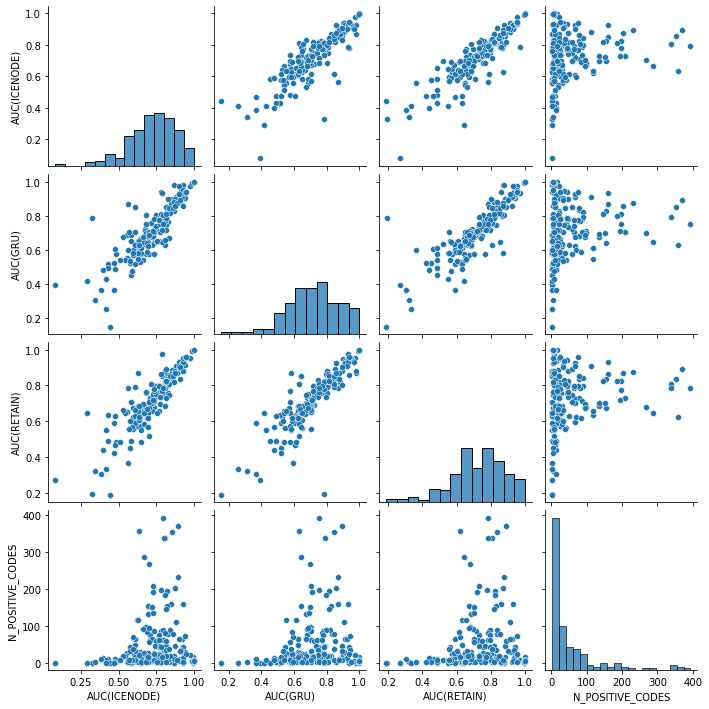

In [94]:
tests_raw_auc_corr = tests_raw[[f'AUC({clf})' for clf in test_res] + ['N_POSITIVE_CODES']]
sns.pairplot(tests_raw_auc_corr)

In [95]:
flatccs_idx2code = {idx: code for code, idx in m3_timestamped_interface.diag_flatccs_idx.items()}
idx2desc = lambda i: m3_timestamped_interface.dag.diag_flatccs_desc[flatccs_idx2code[i]]
tests_raw['DESC'] = tests_raw['CODE_INDEX'].apply(idx2desc)
tests_raw

,CODE_INDEX,N_POSITIVE_CODES,AUC(GRU),AUC(ICENODE),AUC(RETAIN),P0(AUC_GRU==AUC_ICENODE),P0(AUC_GRU==AUC_RETAIN),P0(AUC_ICENODE==AUC_RETAIN),DESC
0,0,4.0,0.687065,0.557463,0.648259,0.086735,0.565084,0.055660,No DX
1,1,17.0,0.541627,0.664967,0.654649,0.131543,0.024450,0.880085,Tuberculosis
2,2,88.0,0.779328,0.785892,0.791309,0.628694,0.300350,0.709598,Immuniz/scrn
3,3,370.0,0.893025,0.894235,0.892391,0.829558,0.903810,0.778590,Acute MI
4,4,18.0,0.720765,0.676365,0.688194,0.426592,0.309803,0.849577,Coron athero
...,...,...,...,...,...,...,...,...,...
178,178,193.0,0.708359,0.729033,0.719172,0.147427,0.364192,0.456712,2ndary malig
179,179,146.0,0.812064,0.815394,0.821930,0.784037,0.272167,0.594779,Malig neopls
180,180,63.0,0.773801,0.771653,0.795144,0.910260,0.172139,0.217504,Neoplsm unsp
181,181,393.0,0.753071,0.795909,0.783126,0.000059,0.000190,0.134757,Maint chem/r


In [96]:
# remove codes that no classifier has scored above 0.6
at_least_AUC_07 = tests_raw.loc[:,[f'AUC({clf})' for clf in test_res]].max(axis=1) > 0.7
tests = tests_raw[at_least_AUC_07]
tests

,CODE_INDEX,N_POSITIVE_CODES,AUC(GRU),AUC(ICENODE),AUC(RETAIN),P0(AUC_GRU==AUC_ICENODE),P0(AUC_GRU==AUC_RETAIN),P0(AUC_ICENODE==AUC_RETAIN),DESC
2,2,88.0,0.779328,0.785892,0.791309,0.628694,0.300350,0.709598,Immuniz/scrn
3,3,370.0,0.893025,0.894235,0.892391,0.829558,0.903810,0.778590,Acute MI
4,4,18.0,0.720765,0.676365,0.688194,0.426592,0.309803,0.849577,Coron athero
5,5,77.0,0.678753,0.708963,0.730882,0.229761,0.007313,0.274904,Chest pain
7,7,111.0,0.906910,0.882983,0.910512,0.063928,0.588049,0.039532,Oth heart dx
...,...,...,...,...,...,...,...,...,...
178,178,193.0,0.708359,0.729033,0.719172,0.147427,0.364192,0.456712,2ndary malig
179,179,146.0,0.812064,0.815394,0.821930,0.784037,0.272167,0.594779,Malig neopls
180,180,63.0,0.773801,0.771653,0.795144,0.910260,0.172139,0.217504,Neoplsm unsp
181,181,393.0,0.753071,0.795909,0.783126,0.000059,0.000190,0.134757,Maint chem/r


In [97]:
tests.isnull().sum()

CODE_INDEX                     0
N_POSITIVE_CODES               0
AUC(GRU)                       0
AUC(ICENODE)                   0
AUC(RETAIN)                    0
P0(AUC_GRU==AUC_ICENODE)       0
P0(AUC_GRU==AUC_RETAIN)        0
P0(AUC_ICENODE==AUC_RETAIN)    0
DESC                           0
dtype: int64

In [98]:
from collections import defaultdict
auc_sets = defaultdict(set)
clfs = tuple(sorted(m3_model.keys()))
clfs_pairs = []
for i in range(len(clfs)):
    for j in range(i + 1, len(clfs)):
        clfs_pairs.append((clfs[i], clfs[j]))
clfs_pairs = tuple(clfs_pairs)

In [99]:
# Extract codes that are predicted with equivalent performance with all classifiers.
test_cols = tuple(f'P0(AUC_{clf1}==AUC_{clf2})' for (clf1, clf2) in clfs_pairs)

In [100]:
common_perf = tests[(tests[test_cols[0]] > 0.05) & (tests[test_cols[1]] > 0.05) & (tests[test_cols[2]] > 0.05)]
auc_sets[clfs] = set(common_perf.CODE_INDEX)

In [101]:
common_perf

,CODE_INDEX,N_POSITIVE_CODES,AUC(GRU),AUC(ICENODE),AUC(RETAIN),P0(AUC_GRU==AUC_ICENODE),P0(AUC_GRU==AUC_RETAIN),P0(AUC_ICENODE==AUC_RETAIN),DESC
2,2,88.0,0.779328,0.785892,0.791309,0.628694,0.300350,0.709598,Immuniz/scrn
3,3,370.0,0.893025,0.894235,0.892391,0.829558,0.903810,0.778590,Acute MI
4,4,18.0,0.720765,0.676365,0.688194,0.426592,0.309803,0.849577,Coron athero
8,8,337.0,0.792590,0.806066,0.806720,0.103630,0.057907,0.935856,Conduction
11,11,46.0,0.789223,0.811752,0.812204,0.270497,0.124251,0.981373,chf;nonhp
...,...,...,...,...,...,...,...,...,...
174,174,16.0,0.714816,0.790345,0.770770,0.064233,0.355594,0.734006,Leukemias
176,176,3.0,0.649105,0.758781,0.647117,0.229285,0.982318,0.535036,Mult myeloma
178,178,193.0,0.708359,0.729033,0.719172,0.147427,0.364192,0.456712,2ndary malig
179,179,146.0,0.812064,0.815394,0.821930,0.784037,0.272167,0.594779,Malig neopls


In [102]:
competing_tests = tests.drop(index=common_perf.index)

In [103]:
for index, row in competing_tests.iterrows():
    max_auc_clf = max(clfs, key=lambda clf: row[f'AUC({clf})'])
    relevant_tests = {(clf1, clf2): f'P0(AUC_{clf1}==AUC_{clf2})' for (clf1, clf2) in clfs_pairs if max_auc_clf in (clf1, clf2)}
    
    significant_max = True
    for (clf1, clf2), test_col in relevant_tests.items():
        # If max_auc_clf has maximum AUC, but without insigificant difference with another classifier
        # then consider both outperforming the third classifier.
        if row[test_col] > 0.05:
            significant_max = False
            auc_sets[(clf1, clf2)].add(int(row['CODE_INDEX']))
    
    if significant_max:
        auc_sets[max_auc_clf].add(int(row['CODE_INDEX']))

In [104]:
# Prepare for using Upset plot

best_sets = {}
for clf in clfs:
    best_sets[clf] = auc_sets[clf] | auc_sets[clfs]
    
    for clf1, clf2 in clfs_pairs:
        if clf in (clf1, clf2):
            best_sets[clf].update(auc_sets[(clf1, clf2)])
    

In [105]:
from upsetplot import from_contents, plot, UpSet
import matplotlib.pyplot as plt

In [106]:
upset_contents = from_contents(best_sets)

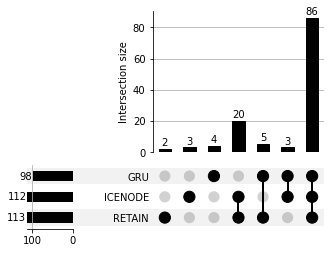

In [107]:
UpSet(upset_contents, subset_size='count', show_counts=True).plot()
plt.show()

In [108]:
model_best_tests = {clf: competing_tests[competing_tests['CODE_INDEX'].isin(best_sets[clf])] for clf in clfs}
model_exc_best_tests = {clf: competing_tests[competing_tests['CODE_INDEX'].isin(auc_sets[clf])] for clf in clfs}

In [109]:
from IPython.display import display

for clf, best_tests in model_best_tests.items():
    print(clf)
    display(best_tests)

GRU


,CODE_INDEX,N_POSITIVE_CODES,AUC(GRU),AUC(ICENODE),AUC(RETAIN),P0(AUC_GRU==AUC_ICENODE),P0(AUC_GRU==AUC_RETAIN),P0(AUC_ICENODE==AUC_RETAIN),DESC
7,7,111.0,0.906910,0.882983,0.910512,6.392821e-02,0.588049,3.953195e-02,Oth heart dx
10,10,353.0,0.848282,0.858262,0.835275,1.643327e-01,0.047707,2.309609e-03,Cardia arrst
14,14,27.0,0.779305,0.792977,0.757091,4.725242e-01,0.233412,1.760182e-02,Precere occl
19,19,8.0,0.633492,0.700050,0.519231,2.884267e-01,0.006471,2.368479e-02,Aneurysm
22,22,2.0,0.939921,0.780536,0.860477,1.119129e-01,0.390987,3.641092e-12,Phlebitis
27,27,2.0,0.977656,0.870904,0.871400,1.517998e-03,0.028061,9.785895e-01,Pneumonia
39,39,2.0,0.785501,0.326216,0.191658,1.936513e-09,0.004664,3.193404e-01,Oth low resp
52,52,10.0,0.869770,0.565265,0.785586,1.125193e-04,0.000002,7.038663e-03,Int obstruct
93,93,3.0,0.579192,0.629887,0.871107,5.062749e-01,0.095194,1.951132e-02,HTN in preg
111,111,10.0,0.847948,0.612212,0.789389,2.307464e-05,0.125053,2.224370e-02,Septicemia


ICENODE


,CODE_INDEX,N_POSITIVE_CODES,AUC(GRU),AUC(ICENODE),AUC(RETAIN),P0(AUC_GRU==AUC_ICENODE),P0(AUC_GRU==AUC_RETAIN),P0(AUC_ICENODE==AUC_RETAIN),DESC
5,5,77.0,0.678753,0.708963,0.730882,0.229761,0.007313,2.749040e-01,Chest pain
10,10,353.0,0.848282,0.858262,0.835275,0.164333,0.047707,2.309609e-03,Cardia arrst
14,14,27.0,0.779305,0.792977,0.757091,0.472524,0.233412,1.760182e-02,Precere occl
18,18,43.0,0.748652,0.816939,0.800388,0.023721,0.013310,3.736743e-01,Perip athero
19,19,8.0,0.633492,0.700050,0.519231,0.288427,0.006471,2.368479e-02,Aneurysm
22,22,2.0,0.939921,0.780536,0.860477,0.111913,0.390987,3.641092e-12,Phlebitis
28,28,5.0,0.702689,0.776693,0.693725,0.014116,0.919937,3.495510e-01,Influenza
33,33,208.0,0.703202,0.728068,0.729437,0.099017,0.042273,9.196308e-01,Asthma
40,40,197.0,0.751031,0.781926,0.776156,0.028931,0.029460,5.975957e-01,Ot uppr resp
45,45,28.0,0.641000,0.736457,0.679591,0.003541,0.196937,1.231302e-01,Gasduo ulcer


RETAIN


,CODE_INDEX,N_POSITIVE_CODES,AUC(GRU),AUC(ICENODE),AUC(RETAIN),P0(AUC_GRU==AUC_ICENODE),P0(AUC_GRU==AUC_RETAIN),P0(AUC_ICENODE==AUC_RETAIN),DESC
5,5,77.0,0.678753,0.708963,0.730882,0.229761,0.007313,2.749040e-01,Chest pain
7,7,111.0,0.906910,0.882983,0.910512,0.063928,0.588049,3.953195e-02,Oth heart dx
18,18,43.0,0.748652,0.816939,0.800388,0.023721,0.013310,3.736743e-01,Perip athero
22,22,2.0,0.939921,0.780536,0.860477,0.111913,0.390987,3.641092e-12,Phlebitis
28,28,5.0,0.702689,0.776693,0.693725,0.014116,0.919937,3.495510e-01,Influenza
33,33,208.0,0.703202,0.728068,0.729437,0.099017,0.042273,9.196308e-01,Asthma
40,40,197.0,0.751031,0.781926,0.776156,0.028931,0.029460,5.975957e-01,Ot uppr resp
45,45,28.0,0.641000,0.736457,0.679591,0.003541,0.196937,1.231302e-01,Gasduo ulcer
49,49,3.0,0.645461,0.788933,0.853545,0.288256,0.044295,3.698612e-01,Appendicitis
57,57,135.0,0.692313,0.732621,0.700856,0.020035,0.537062,6.253537e-02,Rctm/anus ca


In [110]:
for clf, best_tests in model_exc_best_tests.items():
    print(clf)
    display(best_tests)

GRU


,CODE_INDEX,N_POSITIVE_CODES,AUC(GRU),AUC(ICENODE),AUC(RETAIN),P0(AUC_GRU==AUC_ICENODE),P0(AUC_GRU==AUC_RETAIN),P0(AUC_ICENODE==AUC_RETAIN),DESC
27,27,2.0,0.977656,0.870904,0.871400,1.517998e-03,0.028061,0.978589,Pneumonia
39,39,2.0,0.785501,0.326216,0.191658,1.936513e-09,0.004664,0.319340,Oth low resp
52,52,10.0,0.869770,0.565265,0.785586,1.125193e-04,0.000002,0.007039,Int obstruct
177,177,8.0,0.705420,0.567433,0.557817,1.520919e-02,0.018649,0.879181,Ot primry ca


ICENODE


,CODE_INDEX,N_POSITIVE_CODES,AUC(GRU),AUC(ICENODE),AUC(RETAIN),P0(AUC_GRU==AUC_ICENODE),P0(AUC_GRU==AUC_RETAIN),P0(AUC_ICENODE==AUC_RETAIN),DESC
47,47,20.0,0.654752,0.772245,0.657533,0.028041,0.954490,0.029244,Gastritis
60,60,232.0,0.871572,0.893706,0.876869,0.014295,0.404418,0.047915,GI hemorrhag
167,167,21.0,0.716888,0.815500,0.731396,0.033652,0.591990,0.048484,Bladder cncr


RETAIN


,CODE_INDEX,N_POSITIVE_CODES,AUC(GRU),AUC(ICENODE),AUC(RETAIN),P0(AUC_GRU==AUC_ICENODE),P0(AUC_GRU==AUC_RETAIN),P0(AUC_ICENODE==AUC_RETAIN),DESC
139,139,60.0,0.853433,0.815560,0.890929,0.026638,0.045008,0.002234,Ot perint dx
156,156,75.0,0.941185,0.941799,0.956488,0.901322,0.025388,0.038471,Uterus cancr


In [111]:
icenode_best_tests = model_best_tests['ICENODE']
icenode_best_test_above07 = icenode_best_tests[icenode_best_tests['AUC(ICENODE)'] > 0.7]
icenode_best_test_above07

,CODE_INDEX,N_POSITIVE_CODES,AUC(GRU),AUC(ICENODE),AUC(RETAIN),P0(AUC_GRU==AUC_ICENODE),P0(AUC_GRU==AUC_RETAIN),P0(AUC_ICENODE==AUC_RETAIN),DESC
5,5,77.0,0.678753,0.708963,0.730882,0.229761,0.007313,2.749040e-01,Chest pain
10,10,353.0,0.848282,0.858262,0.835275,0.164333,0.047707,2.309609e-03,Cardia arrst
14,14,27.0,0.779305,0.792977,0.757091,0.472524,0.233412,1.760182e-02,Precere occl
18,18,43.0,0.748652,0.816939,0.800388,0.023721,0.013310,3.736743e-01,Perip athero
19,19,8.0,0.633492,0.700050,0.519231,0.288427,0.006471,2.368479e-02,Aneurysm
22,22,2.0,0.939921,0.780536,0.860477,0.111913,0.390987,3.641092e-12,Phlebitis
28,28,5.0,0.702689,0.776693,0.693725,0.014116,0.919937,3.495510e-01,Influenza
33,33,208.0,0.703202,0.728068,0.729437,0.099017,0.042273,9.196308e-01,Asthma
40,40,197.0,0.751031,0.781926,0.776156,0.028931,0.029460,5.975957e-01,Ot uppr resp
45,45,28.0,0.641000,0.736457,0.679591,0.003541,0.196937,1.231302e-01,Gasduo ulcer


## Trajectories for Patients with CCS codes best predicted with ICENODE

### Analyse AUC for Each Admission in the Test Partition

In [33]:
icenode_visit_auc_df = icenode.admissions_auc_scores(icenode_state, test_ids)

In [34]:
icenode_visit_auc_df['N_VISITS'] = icenode_visit_auc_df['SUBJECT_ID'].apply(lambda i: (icenode_visit_auc_df['SUBJECT_ID'] == i).sum())
icenode_visit_auc_df

,SUBJECT_ID,HADM_ID,HADM_IDX,AUC,N_CODES,TIME,INTERVALS,LOS,R/T,NFE,N_VISITS
0,19842,169734,0,0.976900,7.0,412.5,412.5,3.5,0.0,26.0,5
1,19842,186772,1,0.939872,13.0,433.5,21.0,7.5,0.0,20.0,5
2,19842,180229,2,0.947650,8.0,448.5,15.0,3.5,0.0,20.0,5
3,19842,122439,3,0.944203,12.0,509.5,61.0,7.5,0.0,20.0,5
4,19842,163738,4,0.983078,11.0,552.5,43.0,5.5,0.0,20.0,5
...,...,...,...,...,...,...,...,...,...,...,...
1003,26421,192868,1,0.955274,5.0,278.5,186.0,3.5,0.0,26.0,2
1004,2558,105758,0,0.910348,9.0,59.5,59.5,4.5,0.0,20.0,2
1005,2558,194247,1,0.973860,7.0,70.5,11.0,4.5,0.0,14.0,2
1006,10832,196835,0,0.973860,7.0,647.5,647.5,8.5,0.0,26.0,2


In [43]:
visit_auc_subject = icenode_visit_auc_df.groupby('SUBJECT_ID').agg({'AUC': 'mean', 'N_VISITS': 'max', 'N_CODES': ['min', 'max', 'mean', 'median'], 'INTERVALS': ['mean', 'max', 'min'], 'R/T': ['min', 'max', 'mean'] })


In [49]:
best_visit_auc_subjects =  visit_auc_subject[(visit_auc_subject.AUC['mean'] > 0.7) & (visit_auc_subject.N_VISITS['max'] > 1) & (visit_auc_subject.N_VISITS['max'] <10) & (visit_auc_subject.INTERVALS['max'] < 90)]
best_visit_auc_subjects

AUC N_VISITS N_CODES                          INTERVALS  \
                mean      max     min   max       mean median       mean   
SUBJECT_ID                                                                 
2558        0.942104        2     7.0   9.0   8.000000    8.0  35.250000   
3365        0.949252        2     8.0   8.0   8.000000    8.0  57.250000   
9923        0.974690        2     7.0   8.0   7.500000    7.5  25.250000   
10634       0.876059        2     8.0  10.0   9.000000    9.0  22.750000   
10642       0.938640        3     6.0   8.0   7.000000    7.0  31.500000   
14749       0.977719        2     5.0   7.0   6.000000    6.0  39.250000   
17794       0.969620        2     5.0   5.0   5.000000    5.0  82.750000   
21892       0.944567        2     6.0  11.0   8.500000    8.5  49.750000   
22297       0.950857        2     8.0  10.0   9.000000    9.0  78.250000   
22578       0.915018        2     8.0  10.0   9.000000    9.0  54.250000   
26709       0.925885        3    12.0  13.0  12.333333   12.0  37.500000   
31170       0.960470        2     8.0   8.0   8.000000    8.0  28.750000   
40911       0.953608        5    12.0  15.0  14.000000   14.0  43.700000   
46287       0.925373        3     7.0  10.0   8.333333    8.0  47.166667   
47775       0.939398        2    13.0  16.0  14.500000   14.5  36.750000   
49037       0.918251        2     9.0  14.0  11.500000   11.5  17.750000   
56502       0.928084        2     6.0  11.0   8.500000    8.5  14.750000   
57330       0.893318        2    16.0  17.0  16.500000   16.5  38.750000   
59841       0.948664        3    10.0  11.0  10.333333   10.0  43.500000   
63177       0.949991        2    15.0  17.0  16.000000   16.0  46.750000   
66256       0.948508        2    13.0  14.0  13.500000   13.5  13.250000   
72847       0.927071        2     4.0   9.0   6.500000    6.5  49.250000   
77413       0.928496        2    11.0  13.0  12.000000   12.0  27.250000   
78419       0.911054        2     8.0  11.0   9.500000    9.5  45.750000   
98336       0.922957        2    15.0  20.0  17.500000   17.5  31.250000   

                        R/T            
             max   min  min  max mean  
SUBJECT_ID                             
2558        59.5  11.0  0.0  0.0  0.0  
3365        84.5  30.0  0.0  0.0  0.0  
9923        33.5  17.0  0.0  0.0  0.0  
10634       30.5  15.0  0.0  0.0  0.0  
10642       43.0  23.0  0.0  0.0  0.0  
14749       50.5  28.0  0.0  0.0  0.0  
17794       85.0  80.5  0.0  0.0  0.0  
21892       62.5  37.0  0.0  0.0  0.0  
22297       83.0  73.5  0.0  0.0  0.0  
22578       57.5  51.0  0.0  0.0  0.0  
26709       49.5  27.0  0.0  0.0  0.0  
31170       43.0  14.5  0.0  0.0  0.0  
40911       69.0   7.0  0.0  0.0  0.0  
46287       76.5   7.0  0.0  0.0  0.0  
47775       41.0  32.5  0.0  0.0  0.0  
49037       18.5  17.0  0.0  0.0  0.0  
56502       21.0   8.5  0.0  0.0  0.0  
57330       42.5  35.0  0.0  0.0  0.0  
59841       73.0  24.5  0.0  0.0  0.0  
63177       57.5  36.0  0.0  0.0  0.0  
66256       22.5   4.0  0.0  0.0  0.0  
72847       64.0  34.5  0.0  0.0  0.0  
77413       36.0  18.5  0.0  0.0  0.0  
78419       53.0  38.5  0.0  0.0  0.0  
98336       44.0  18.5  0.0  0.0  0.0

In [50]:
ccs_history = {i: icnode_patient_interface.diag_flatccs_history(i)[1] for i in best_visit_auc_subjects.index}

In [51]:
ccs_history_icenode_best = {i: history for i, history in ccs_history.items() if len(set(history) & set(icenode_best_test_above07['CODE_INDEX']))> 0}

In [52]:
ccs_history_icenode_best

{3365: [240, 66, 155, 238, 11, 37, 9, 190, 184, 4, 100, 44],
 9923: [187,
  238,
  11,
  64,
  12,
  189,
  4,
  65,
  241,
  184,
  63,
  58,
  190,
  185,
  196,
  239],
 17794: [18, 40, 240, 19, 9, 190, 4, 15],
 22578: [115,
  240,
  11,
  64,
  9,
  4,
  125,
  32,
  6,
  155,
  55,
  111,
  190,
  53,
  5,
  3,
  41,
  22,
  175],
 31170: [48, 155, 47, 209, 60, 198, 195, 212, 22, 44, 200, 184],
 40911: [18,
  187,
  39,
  27,
  198,
  113,
  241,
  71,
  117,
  6,
  191,
  190,
  226,
  8,
  185,
  192,
  21,
  238,
  11,
  64,
  37,
  3,
  237,
  9,
  33,
  183,
  189,
  65,
  4,
  66,
  60,
  155,
  164,
  196],
 49037: [240,
  70,
  119,
  37,
  64,
  22,
  197,
  10,
  198,
  33,
  60,
  66,
  58,
  164,
  185,
  196,
  192,
  44,
  200,
  175],
 56502: [39, 37, 84, 33, 209, 203, 40, 188, 131, 220, 196, 192],
 57330: [240,
  27,
  241,
  195,
  191,
  47,
  190,
  200,
  21,
  37,
  64,
  11,
  3,
  237,
  68,
  33,
  183,
  209,
  4,
  65,
  32,
  145,
  111,
  178,
  53,
  1

In [53]:
len(ccs_history_icenode_best)

14

In [ ]:
trajectory = icenode.sample_trajectory(icenode_state, ccs_history_icenode_best.keys(), 1)

  0%|                                                                                                                                                                               | 0/41 [00:00<?, ?it/s]/home/asem/GP/ICENODE/analysis/../icenode/train_icenode_tl.py:408: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  pos[[top10_idx]] = 1
  2%|████                                                                                                                                                                | 1/41 [12:31<8:21:00, 751.52s/it]

In [97]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [99]:
ccs_index = list(icenode_best_test_above07['CODE_INDEX'])
idx2desc = lambda idx: icnode_patient_interface.dag.diag_flatccs_desc[flatccs_idx2code[idx]]
ccs_description = list(map(idx2desc, ccs_index))


In [101]:
data = {}
for i, traj in trajectory.items():
    diag_times = icnode_patient_interface.diag_times(i)
    
    t = traj['t']
    d = traj['d']
    
    prob = []
    time = []
    code = []
    
    for ccs_desc, ccs_idx in zip(ccs_description, ccs_index):
        time.append(t)
        code.extend([ccs_desc]*len(t))
        prob.append(d[:, ccs_idx])

    prob = np.hstack(prob)
    time = np.hstack(time)
    
    
    df = pd.DataFrame({'t': time, r'$\hat{v}$': prob, 'code': code})
    data[i] = (df, diag_times)
    

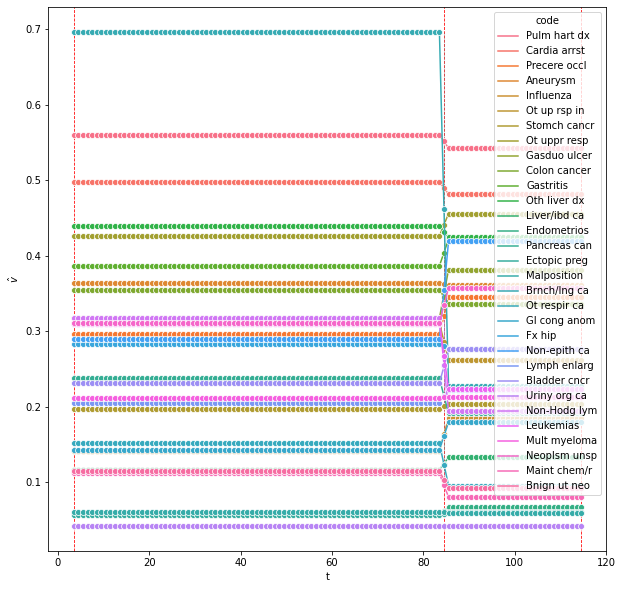

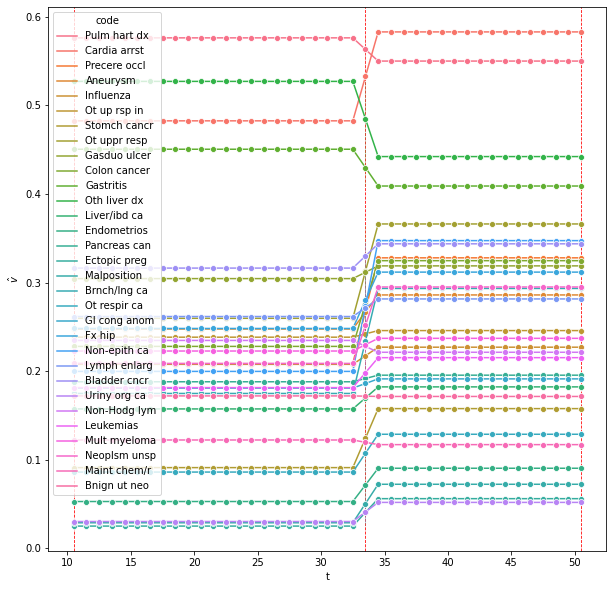

In [116]:
plt.rcParams['figure.figsize']=(10,10)
import math
for i, (df, diag_times) in data.items():

    plt.figure(i)
    
    g = sns.lineplot(data=df, x="t", y=r'$\hat{v}$', hue='code', marker='o')
    for diag_time in diag_times:
        g.axvline(x=diag_time, ymin=0, ymax=1, c="red", ls='--', linewidth=0.8, zorder=0, clip_on=False)

It seems that we cannot catch the smoothness of the trajectory as it evolves very quickly to the saturation value.